<a href="https://colab.research.google.com/github/eschwarzbeckf/forecast_prices/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 6.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox as box
from scipy.stats import norm, shapiro

In [6]:
from sktime.utils.plotting import plot_series, plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import StatsModelsARIMA
from sktime.split import temporal_train_test_split, SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.boxcox import LogTransformer

In [8]:
df = pd.read_csv("consolidated.csv",parse_dates=True,index_col=0)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sales'>)

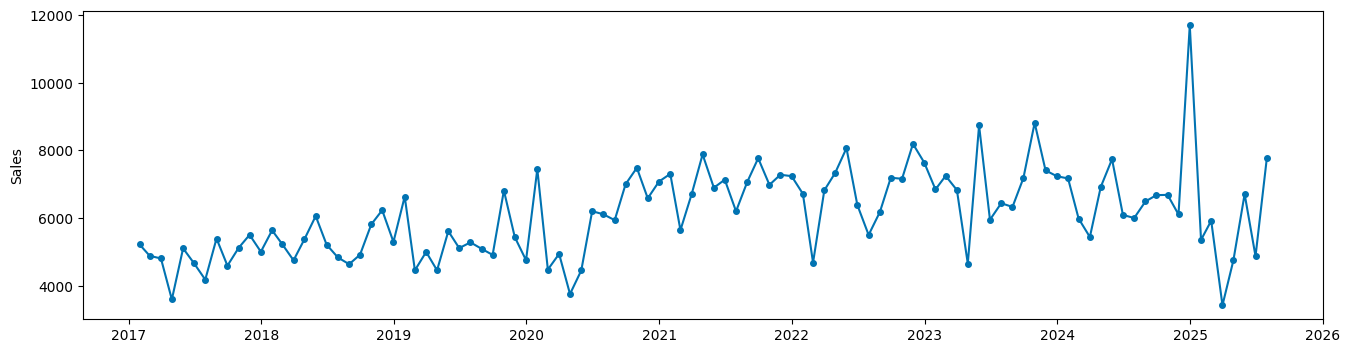

In [9]:
plot_series(df)

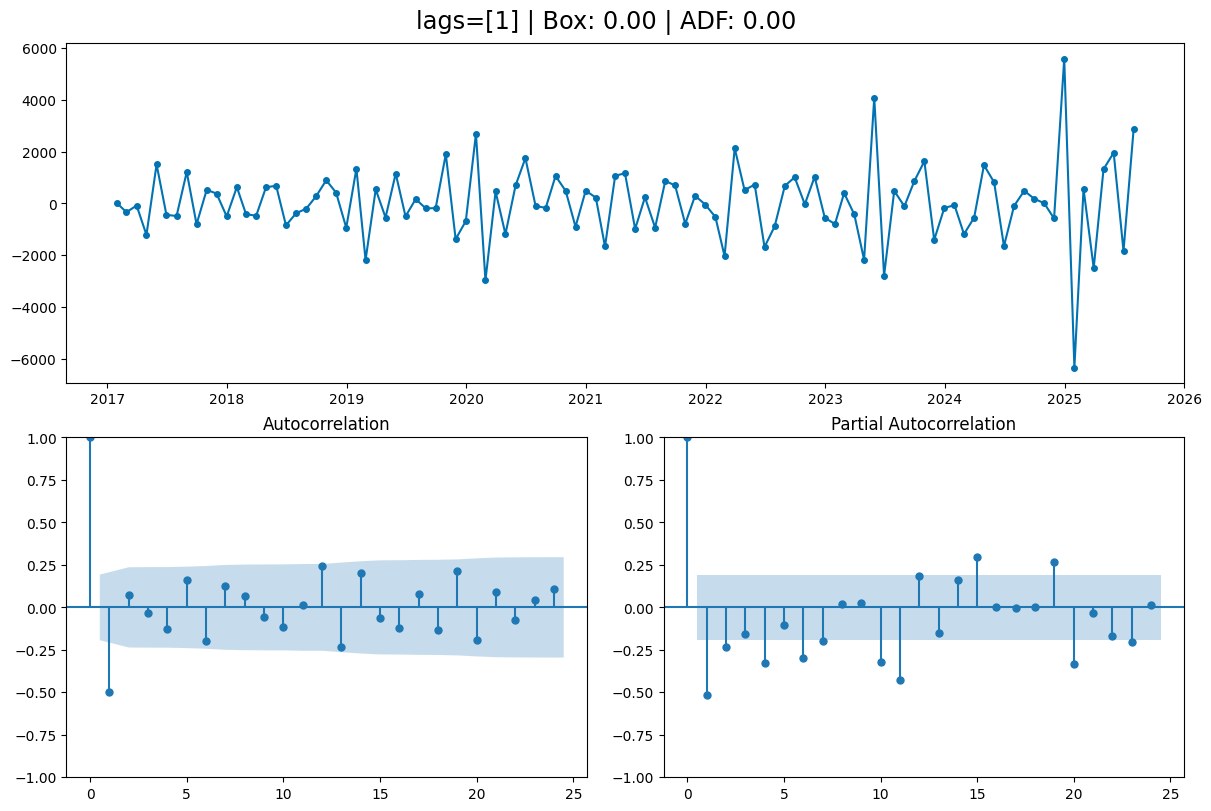

In [11]:
lags=[1]
y = df if lags == 0 else Differencer(lags=lags).fit_transform(df)
plot_correlations(y,pacf_method='ols',suptitle=f"lags={lags} | Box: {box(y,lags=12)['lb_pvalue'].values[-1]:.2f} | ADF: {adfuller(y,maxlag=12)[1]:.2f}")
plt.show()

In [14]:
y_train, y_test = temporal_train_test_split(df, test_size=12)
model = StatsModelsARIMA(order=(0,1,1),seasonal_order=(1,0,1,12),trend='n')
model.fit(y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   91
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -735.877
Date:                          Thu, 11 Sep 2025   AIC                           1479.754
Time:                                  12:59:07   BIC                           1489.754
Sample:                              01-31-2017   HQIC                          1483.787
                                   - 07-31-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7776      0.073    -10.643      0.000      -0.921      -0.634
ar.S.L12      -0.2090      0.247     -0.846      0.398      -0.693       0.275
ma.S.L12       0.6341      0.234      2.712      0.007       0.176       1.092
sigma2      6.934e+05   1.06e+05      6.536      0.000    4.85e+05    9.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.84   Prob(JB):                         0.78
Heteroskedasticity (H):               2.78   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


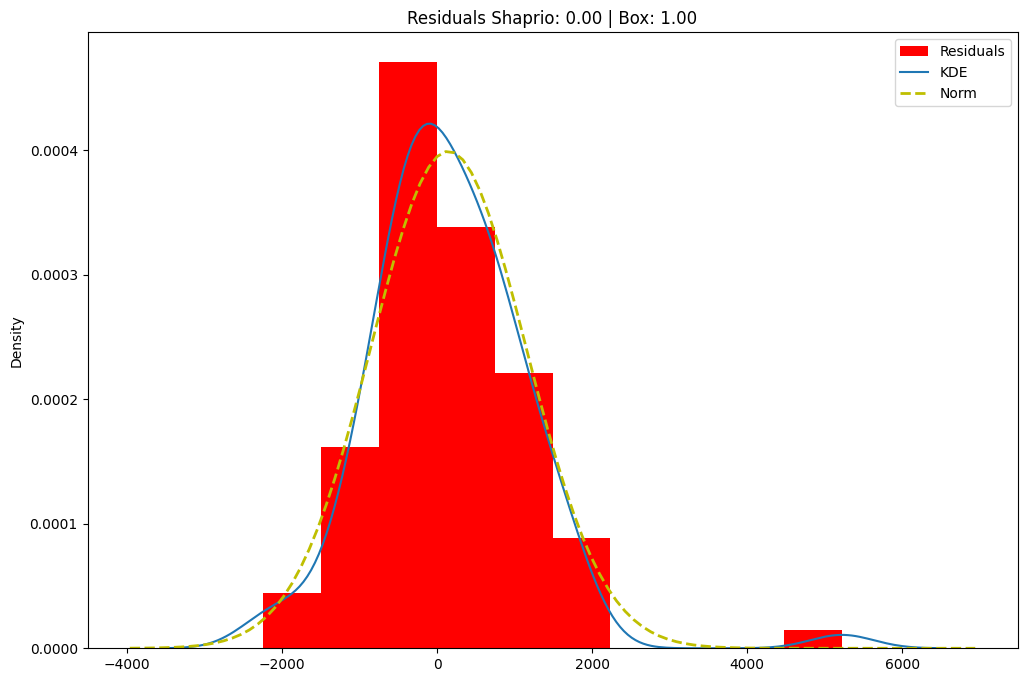

In [15]:
res = y_train - model.predict(fh=-np.arange(len(y_train)))
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(res,density=True,color='red',label='Residuals')
sns.kdeplot(res,label='KDE',ax=ax)
mu, std = norm.fit(res)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'y--', linewidth=2,label='Norm')
ax.set_title(f'Residuals Shaprio: {shapiro(res)[1]:.2f} | Box: {box(res,lags=12)['lb_pvalue'].values[-1]:.2f}')
ax.legend()
plt.show()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

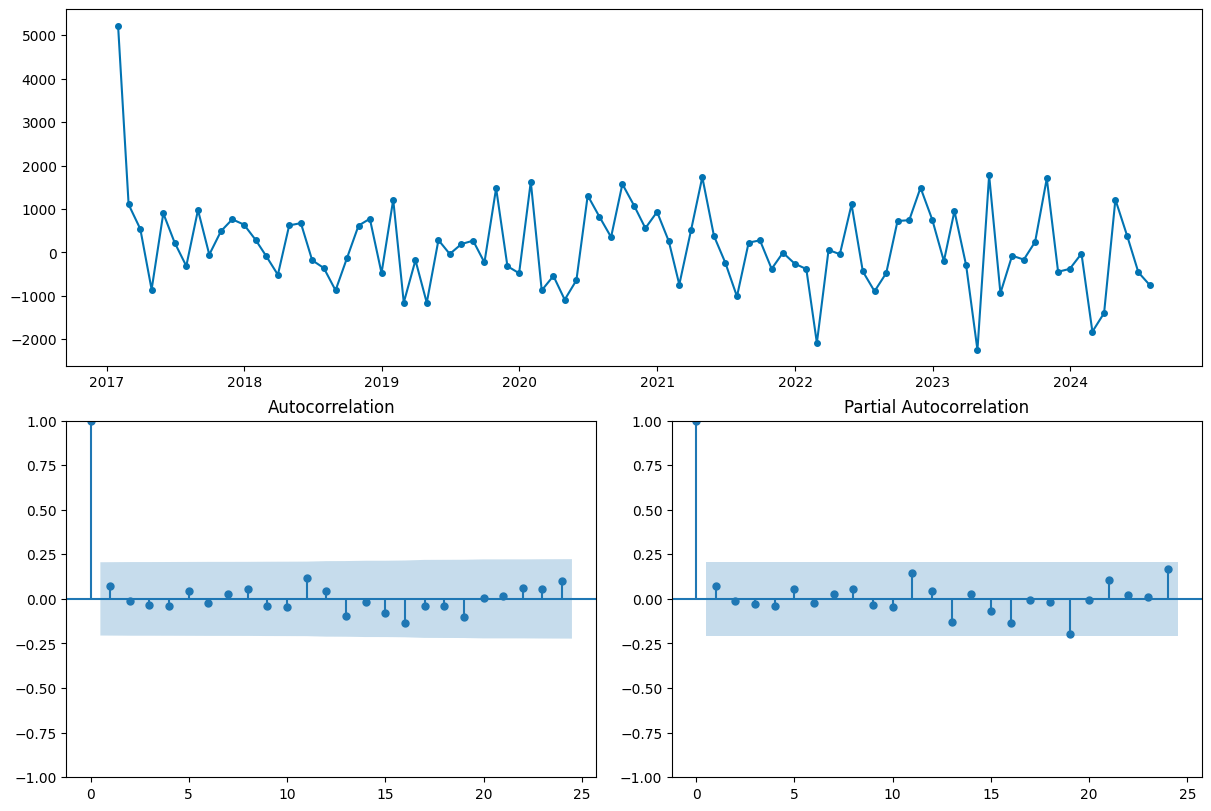

In [17]:
plot_correlations(res,pacf_method='ols')

In [20]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['random_state']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


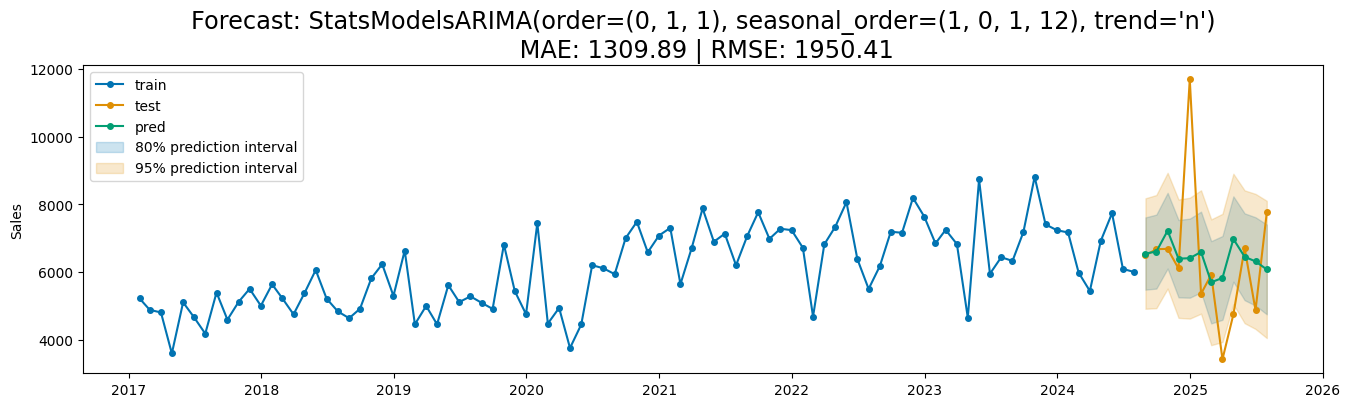

In [21]:
y_pred = model.predict(fh=y_test.index)
y_ci = model.predict_interval(fh=y_test.index, coverage=[.8,.95])
plot_series(y_train,y_test,y_pred,labels=['train','test','pred'],title=f'Forecast: {model}\n MAE: {mae.evaluate(y_test,y_pred):.2f} | RMSE: {rmse.evaluate(y_test,y_pred):.2f}',pred_interval=y_ci)
plt.show()

In [23]:
cv=ExpandingWindowSplitter(fh=np.arange(1,4),step_length=3,initial_window=len(df)-3*4)
results = evaluate(model,cv=cv,y=df,scoring=[mae,rmse],return_data=True)

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed

/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/usr/local/lib/python3.12/dist-packages/sktime/forecasting/base/_fh.py:861: FutureWarning: 'M' is deprecated and will be removed

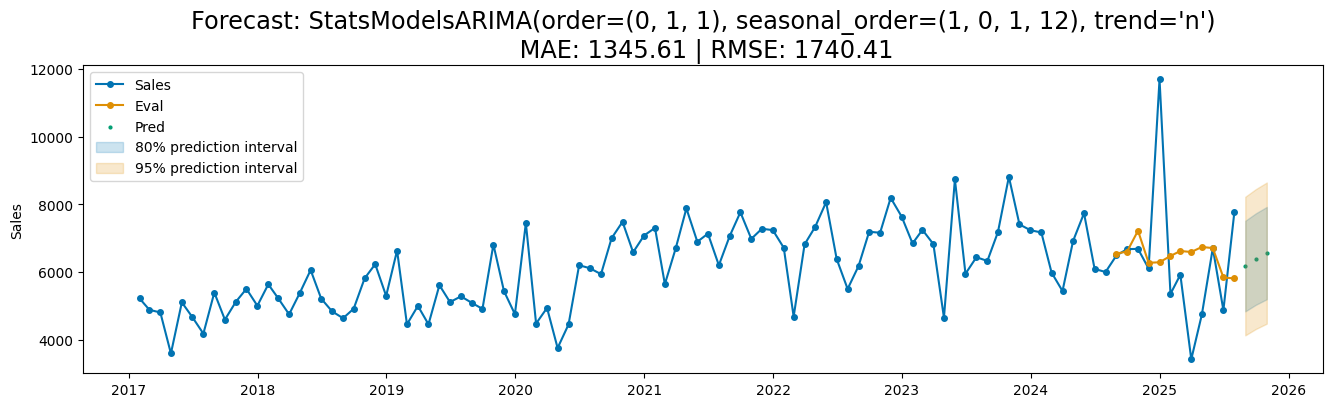

In [24]:
b = ['Sales']
test = pd.DataFrame()
for i,d in enumerate(results['y_pred']):
  test = pd.concat([test,d])
b.append('Eval')
model.fit(df)
y_pred = model.predict(fh=np.arange(1,4))
b.append('Pred')
y_ci = model.predict_interval(fh=np.arange(1,4),coverage=[0.8,0.95])

plot_series(df,test,y_pred,labels=b,title=f'Forecast: {model}\n MAE: {results['test_MeanAbsoluteError'].mean():.2f} | RMSE: {results['test_MeanSquaredError'].mean():.2f}',pred_interval=y_ci)
plt.show()